In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from collections import deque

import torch
from torch.utils.tensorboard import SummaryWriter

from Gridworld import Gridworld

Run `tensorboard` using `tensorboard --logdirs=runs`

In [94]:
def render_strategy(game, model):
    action_set_vis = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    occupied = [game.board.components[piece].pos
                for piece in ["Goal", "Pit", "Wall"]]
    game_render = game.display()
    state_len = 4*game.board.size**2
    for row in range(game.board.size):
        for col in range(game.board.size):
            if (row, col) not in occupied:
                game.board.movePiece("Player", (row, col))
                game_state_ = game.board.render_np().reshape(1, state_len)
                game_state = torch.from_numpy(game_state_).float()
                q_predicted = model(game_state)
                action_ = torch.argmax(q_predicted).item()
                action = action_set_vis[action_]
                game_render[row, col] = action
    return game_render

In [95]:
def create_q_network(size, h1_size=150, h2_size=100):
    return torch.nn.Sequential(
        torch.nn.Linear(4*size**2, h1_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h1_size, h2_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h2_size, 4))

In [96]:
def compute_epsilon(epsilon_current, delta_epsilon, epsilon_min):
    epsilon_new = epsilon_current - delta_epsilon
    if epsilon_new < epsilon_min:
        epsilon_new = epsilon_min
    return epsilon_new

In [97]:
action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}

def take_action(game, action, noise_level=0.1):
    if action is not None:
        game_action = action_set[action]
        game.makeMove(game_action)
        reward = game.reward()
    else:
        reward = None
    state_len = 4*game.board.size**2
    new_state_ = game.board.render_np().reshape(1, state_len) + noise_level*np.random.rand(1, state_len)
    new_state = torch.from_numpy(new_state_).float()
    return new_state, reward

In [98]:
def choose_action(model, state, epsilon):
    q_values = model(state)
    q_values_ = q_values.data.numpy()
    if random.random() < epsilon:
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(q_values_)
    return action, q_values

In [99]:
def compute_loss(loss_function, model, experience, discounting_factor, minibatch_size):
    if len(experience) >= minibatch_size:
        minibatch = random.sample(experience, minibatch_size)
        states = torch.cat([s_ for (s_, a_, r_, new_s_, done_) in minibatch])
        actions = torch.Tensor([a_ for (s_, a_, r_, new_s_, done_) in minibatch])
        rewards = torch.Tensor([r_ for (s_, a_, r_, new_s_, done_) in minibatch])
        new_states = torch.cat([new_s_ for (s_, a_, r_, new_s_, done_) in minibatch])
        done = torch.Tensor([done_ for (s_, a_, r_, new_s_, done_) in minibatch])

        q_values = model(states)
        with torch.no_grad():
            new_q_values = model(new_states)

        max_q_value = torch.max(new_q_values, dim=1)[0]
        target = (rewards + discounting_factor * (1 - done) * max_q_value).reshape(minibatch_size)
        predict = q_values.gather(dim=1, index=actions.long().unsqueeze(dim=1)).squeeze().reshape(minibatch_size)
        return loss_function(predict, target.detach())

In [100]:
def create_loss_and_optimizer(model, learning_rate):
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return loss_function, optimizer

In [101]:
def update_weights(optimizer, loss_value):
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

In [102]:
game_mode = 'random'
game_size = 6

In [103]:
q_network = create_q_network(size=game_size)

gw = Gridworld(size=game_size, mode=game_mode)
render_strategy(gw, q_network)

array([['↑', '↑', '↑', '↑', '↑', '↑'],
       ['↑', '↑', 'W', '↑', '↑', '↑'],
       ['↑', '↑', '↑', '↑', '↑', '↑'],
       ['↑', '↑', '↑', '↑', '↑', '+'],
       ['↑', '↑', '↑', '-', '↑', '↑'],
       ['↑', '↑', '↑', '↑', '↑', '↑']], dtype='<U2')

In [104]:
gamma = 0.9
eps = 1.0

epochs = 2000
losses = []
actions_per_game = []
max_actions_per_game = 50

experience_size = 1000
batch_size = 200

exp = deque(maxlen=experience_size)
writer = SummaryWriter(flush_secs=1)

loss_fn, qnn_optimizer = create_loss_and_optimizer(q_network, 1e-3)
for i in (pbar := trange(epochs)):

    gw = Gridworld(size=game_size, mode=game_mode)
    s, _ = take_action(gw, action=None)

    actions_taken = 0
    total_loss = 0
    while True:
        a, q = choose_action(q_network, s, eps)

        new_s, r = take_action(gw, a)
        actions_taken += 1
        terminate = (r != -1) or \
                    (actions_taken == max_actions_per_game)

        exp.append((s, a, r, new_s, terminate))
        loss = compute_loss(loss_fn, q_network, exp, gamma, batch_size)
        if loss is not None:
            update_weights(qnn_optimizer, loss)
            total_loss += loss.item()

        s = new_s

        if terminate:
            writer.add_scalar("train/loss", total_loss/actions_taken, i)
            writer.add_scalar("train/actions", actions_taken, i)
            pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
            break

    eps = compute_epsilon(eps, delta_epsilon=1 / epochs, epsilon_min=0.1)

writer.flush()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [105]:
gw = Gridworld(size=game_size, mode=game_mode)
render_strategy(gw, q_network)

array([['→', '→', '→', '→', '↓', '→'],
       ['→', '+', '←', '→', '↓', '←'],
       ['←', '↓', '↓', '↓', '→', '↑'],
       ['→', '↓', 'W', '→', '→', '→'],
       ['←', '→', '→', '↓', '↑', '←'],
       ['←', '↑', '↓', '-', '→', '↓']], dtype='<U2')

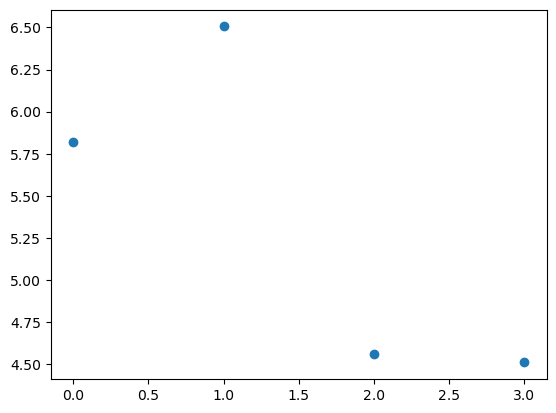

In [21]:
# gw = Gridworld(size=4, mode='static')
st_ = gw.board.render_np().reshape(1, 64)
st = torch.from_numpy(st_).float()
q_vals = q_network(st).detach().numpy()
plt.scatter(x=range(4), y=q_vals);